# PlaneswalkerAI | Modelo Mejorado
## Reconocimiento de color de Cartas de Magic: The Gathering con CNN.
## Grant Keegan | A017007

Este código descarga los datos de Google Drive. Las 3,436 imágenes de las cartas de Magic The Gathering, junto con el archivo csv conteniendo los metadatos de cada una, indicando sus colores.

Los datos se dividen en entrenamiento, prueba y validación. Después se crea el entrenamiento de las cartas con una red neuronal convolucional (CNN). Al final, se evalúa el desempeño de la etiqueta verdadera vs la predecida con el set de prueba.

En esta versión mejorada, se cambia la arquitectura de la CNN **Se agrega una técnica de regularización** L2, se modifica el optimizador Adam para ajustar el learning rate, se ajustan los epochs a 30 y se ajusta el tamaño del kernel para evitar overfitting en el entrenamiento y asegurar mejores resultados.

In [1]:
# Instalamos dependencias.

# Dependencias de herramientas básicas
import os
import numpy as np # Para cálculos matemáticos en ciertas funciones.
import pandas as pd # Para cargar los dataframes del csv.
import matplotlib.pyplot as plt # Para mostrar las gráficas de desempeño.
from tqdm import tqdm # Para visualizar el proceso de carga.
import cv2 # Para visualizar las cartas.
from google.colab import drive # Para cargar drive.

# Importamos dependencias de keras.
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

# Dependencias para usar ResNet50
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# Dependencias de keras para mejorar el modelo.
from keras.layers import GlobalAveragePooling2D
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

# Dependencias para las métricas del entrenamiento.
from keras import backend as K
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Cargamos google drive con los datos del proyecto.
drive.mount('/content/drive')

# Importamos el directorio con nuestras imágenes de cartas (Son 3436).
card_directory = "/content/drive/MyDrive/RETO MAGIC/mtg_standard_cards"
print("Dataset:", card_directory)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset: /content/drive/MyDrive/RETO MAGIC/mtg_standard_cards


In [3]:
# Leemos el csv con los metadatos de colores en one-hot encoding.
df = pd.read_csv("/content/drive/MyDrive/RETO MAGIC/card_metadata.csv")
print(df.head(20))
print(df.columns)

                                             name         colors  Colorless  \
0                          Aatchik Emerald Radian         [B, G]          0   
1                            Abandoned Campground  ['Colorless']          1   
2                                Abhorrent Oculus          ['U']          0   
3                                          Abrade          ['R']          0   
4                                  Abraded Bluffs  ['Colorless']          1   
5                                 Absolute Virtue         [U, W]          0   
6                               Absolving Lammasu          ['W']          0   
7                           Abuelo Ancestral Echo         [U, W]          0   
8                             Abyssal Gorestalker          ['B']          0   
9                               Abyssal Harvester          ['B']          0   
10                                  Abzan Devotee          ['B']          0   
11                                 Abzan Monument  [

In [4]:
files = os.listdir(card_directory)

# Ordenar por nombre.
files = sorted(files)

# Imprimir los primeros 20.
for f in files[:20]:
    print(f)

A Killer Among Us.jpg
A Realm Reborn.jpg
A Tale for the Ages.jpg
Aatchik Emerald Radian.jpg
Abandoned Campground.jpg
Abhorrent Oculus.jpg
Abrade.jpg
Abraded Bluffs.jpg
Absolute Virtue.jpg
Absolving Lammasu.jpg
Abuelo Ancestral Echo.jpg
Abyssal Gorestalker.jpg
Abyssal Harvester.jpg
Abzan Devotee.jpg
Abzan Monument.jpg
Aclazotz Deepest Betrayal  Temple of the Dead.jpg
Acolyte of Aclazotz.jpg
Acrobatic Cheerleader.jpg
Acrobatic Leap.jpg
Adagia Windswept Bastion.jpg


# Preprocesamiento nuevo.

In [5]:
def load_and_preprocess(path, target_size=(224, 224)):
    # Cargar imagen con OpenCV
    img = cv2.imread(path)

    # Convertir de BGR a RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize con padding para no deformar
    h, w = img.shape[:2]
    scale = min(target_size[0] / h, target_size[1] / w)
    new_w, new_h = int(w * scale), int(h * scale)
    resized = cv2.resize(img, (new_w, new_h))

    # Crear lienzo cuadrado
    canvas = np.zeros((target_size[0], target_size[1], 3), dtype=np.uint8)
    pad_w = (target_size[1] - new_w) // 2
    pad_h = (target_size[0] - new_h) // 2
    canvas[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized

    # Convertir a array y aplicar preprocess_input
    canvas = np.array(canvas)
    canvas = preprocess_input(canvas)

    return canvas

In [6]:
# Definimos el arreglo de X y Y de los datos y cargamos las imágenes en el X dataset.

X_dataset = []
for i in tqdm(range(df.shape[0])):
  img_name = df['name'][i] + '.jpg'
  img_path = os.path.join(card_directory, img_name)
  img = load_and_preprocess(img_path)
  X_dataset.append(img)

X = np.array(X_dataset)

# Genera las etiquetas con one-hot encoding.
Y = np.array(df.drop(['name', 'colors'], axis = 1))

100%|██████████| 3436/3436 [01:12<00:00, 47.64it/s]


In [7]:
# Definimos el split de entrenamiento con sklearn.
X_temp, X_test, Y_temp, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_temp, Y_temp, test_size=0.176, random_state=42)

# Mostrar resultados de división entre train, test y val.
print(f"\nX_train: ({X_train.shape[0]} cartas de 3,426)")
print(f"\nX_test:  ({X_test.shape[0]} cartas de 3,426)")
print(f"\nX_val:   ({X_val.shape[0]} cartas de 3,426)")

print(f"\nY_train: ({Y_train.shape[0]} cartas de 3,426)")
print(f"\nY_test:  ({Y_test.shape[0]} cartas de 3,426)")
print(f"\nY_val:   ({Y_val.shape[0]} cartas de 3,426)")


X_train: (2406 cartas de 3,426)

X_test:  (516 cartas de 3,426)

X_val:   (514 cartas de 3,426)

Y_train: (2406 cartas de 3,426)

Y_test:  (516 cartas de 3,426)

Y_val:   (514 cartas de 3,426)


In [8]:
# Guardamos los indices originales de las cartas.
# Esto nos ayuda a utilizar las cartas para las pruebas al final.
indices_originales = np.arange(len(df))

idx_temp, idx_test  = train_test_split(indices_originales, test_size=0.15, random_state=42)
idx_train, idx_val  = train_test_split(idx_temp, test_size=0.176, random_state=42)

# Construcción y entrenamiento del modelo.

## Cambios para la arquitectura del modelo:
### * Implementamos una arquitectura ResNet50 en vez de CNN base.
* Preprocessamiento de imágenes (x_size y y_size) se cambian de 255x180 a 224x224. MUY IMPORTANTE.
* Aplicar regularización L2 con weight decay.
* Cambiar el tamaño de los kernels de 5x5 a 3x3.
* Cambiar dropout de 0.2 a 0.25
* Eliminar cuarta convolución.
* Cambiar flatten a GlobalAveragePooling2D (menos parámetros).
* Ajustamos el learning rate del optimizador Adam.

In [9]:
# Tamaño de las imágenes
x_size = 224
y_size = 224
input_shape = (x_size, y_size, 3)

# Regularización L2
weight_decay = 1e-4

# ResNet50 como base.
inputs = Input(shape=input_shape)

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# Congelamos la base para la primera fase de entrenamiento
base_model.trainable = False

# Capa de clasificación colores MTG.
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Capa densa final con L2
x = Dense(
    128,
    activation='relu',
    kernel_regularizer=l2(weight_decay)
)(x)

x = BatchNormalization()(x)
x = Dropout(0.40)(x)

# Capa de salida para 6 colores (multietiqueta)
outputs = Dense(
    6,
    activation='sigmoid',
    kernel_regularizer=l2(weight_decay)
)(x)

# Creamos el modelo final
model = Model(inputs=inputs, outputs=outputs)

# Compilación
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,270 (90.99 MB)

 Trainable params: 263,302 (1.00 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

In [10]:
# Entrenamos el modelo.
history = model.fit(
    X_train, Y_train,
    epochs=20,
    validation_data=(X_val, Y_val),
    batch_size=64,
)

Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 47s 657ms/step - accuracy: 0.4075 - loss: 0.7850 - val_accuracy: 0.6576 - val_loss: 0.7058
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 199ms/step - accuracy: 0.8301 - loss: 0.4958 - val_accuracy: 0.8307 - val_loss: 0.5085
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 203ms/step - accuracy: 0.8642 - loss: 0.4195 - val_accuracy: 0.8599 - val_loss: 0.4624
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 201ms/step - accuracy: 0.8726 - loss: 0.3540 - val_accuracy: 0.8755 - val_loss: 0.3721
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.8938 - loss: 0.2967 - val_accuracy: 0.8677 - val_loss: 0.3192
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 210ms/step - accuracy: 0.9038 - loss: 0.2462 - val_accuracy: 0.9027 - val_loss: 0.2533
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - accuracy: 0.9066 - loss: 0.2103 - val_accuracy: 0.8969 - val_loss: 0.2854
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 218ms/step - accuracy: 0.9270 - loss: 0.1750 - val_accuracy: 0

# Muestra de métricas del modelo.

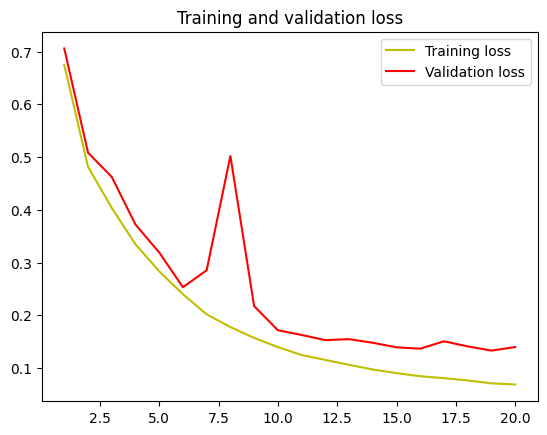

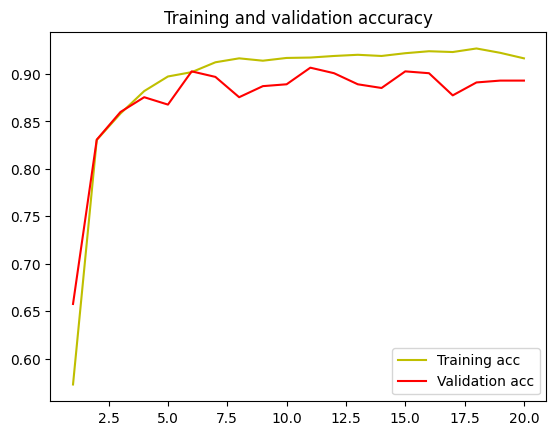

In [11]:
# Mostramos las gráficas del entrenamiento y validación.
# Vamos a evaluarlos con el set de test al final.
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [ ]:
# Predicciones
pred_train = model.predict(X_train)
pred_val   = model.predict(X_val)
pred_test  = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


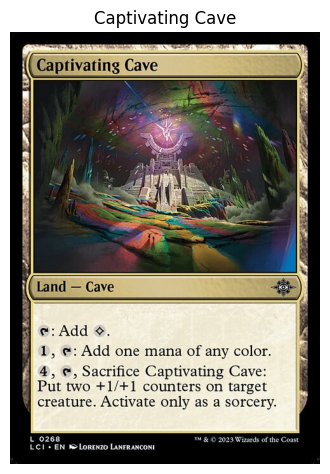


Imagen 378 
Carta: Captivating Cave

Real:
  🔘 Colorless: 1
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 1.00
  🔴 Red: 0.01
  🔵 Blue: 0.02
  🟢 Green: 0.01
  ⚫ Black: 0.17
  ⚪ White: 0.02

Tu carta es incolora.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


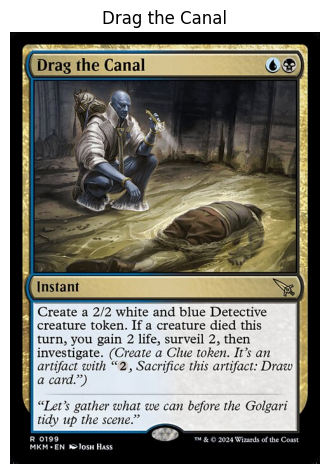


Imagen 12 
Carta: Drag the Canal

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 1
  🟢 Green: 0
  ⚫ Black: 1
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.01
  🔴 Red: 0.01
  🔵 Blue: 0.82
  🟢 Green: 0.02
  ⚫ Black: 0.59
  ⚪ White: 0.42

Tu carta es azul.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


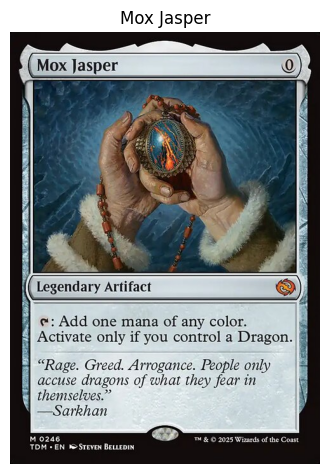


Imagen 362 
Carta: Mox Jasper

Real:
  🔘 Colorless: 1
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.66
  🔴 Red: 0.01
  🔵 Blue: 0.08
  🟢 Green: 0.12
  ⚫ Black: 0.00
  ⚪ White: 0.02

Tu carta es incolora.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


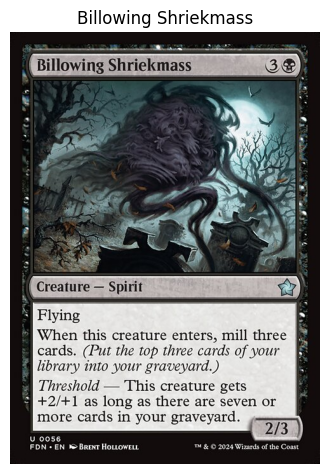


Imagen 303 
Carta: Billowing Shriekmass

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 1
  ⚪ White: 0

Predicción:
  🔘 Colorless: 0.00
  🔴 Red: 0.00
  🔵 Blue: 0.03
  🟢 Green: 0.00
  ⚫ Black: 1.00
  ⚪ White: 0.02

Tu carta es negra.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


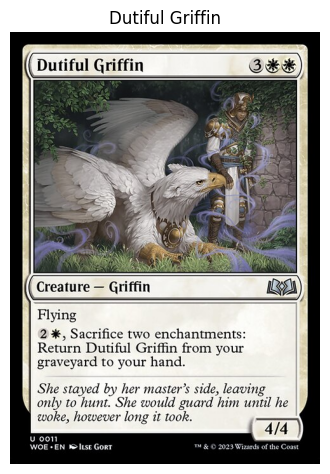


Imagen 400 
Carta: Dutiful Griffin

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 0
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 1

Predicción:
  🔘 Colorless: 0.01
  🔴 Red: 0.00
  🔵 Blue: 0.00
  🟢 Green: 0.00
  ⚫ Black: 0.00
  ⚪ White: 1.00

Tu carta es blanca.


In [14]:
# Generamos las etiquetas de colores para visualizar resultados.
color_labels = [
    ("Colorless", "🔘"),
    ("Red", "🔴"),
    ("Blue", "🔵"),
    ("Green", "🟢"),
    ("Black", "⚫"),
    ("White", "⚪")
]

# Definimos la cantidad de cartas que queremos mostrar.
num_examples = 5
# Usamos los índices originales de las cartas que guardamos antes.
indices = np.random.choice(len(X_test), num_examples, replace=False)

for idx in indices:

    # Predicción
    pred = model.predict(X_test[idx:idx+1])[0]
    true = Y_test[idx]

    # índice con el nombre de la carta
    idx_real = idx_test[idx]
    card_name = df.iloc[idx_real]['name']

    # Cargar imagen de la carta.
    img_path = os.path.join(card_directory, card_name + ".jpg")
    img_original = cv2.imread(img_path)

    # Mostrar imagen redimensionada.
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,6))
    plt.imshow(img_original)
    plt.title(card_name)
    plt.axis('off')
    plt.show()

    # Texto
    print(f"\nImagen {idx} ")
    print("Carta:", card_name)

    print("\nReal:")
    for (label, emoji), val in zip(color_labels, true):
        print(f"  {emoji} {label}: {val}")

    print("\nPredicción:")
    for (label, emoji), p in zip(color_labels, pred):
        print(f"  {emoji} {label}: {p:.2f}")

    # Mostrar el texto que indica el color de la carta:
    threshold = 0.60
    colores_detectados = []

    for (label, emoji), val in zip(color_labels, pred):
        if val >= threshold:
            colores_detectados.append(label)

    # Generar texto de predicción de la carta.
    if len(colores_detectados) == 0:
        print("\nNo se detectó ningún color con confianza suficiente.")
    else:
        traduccion = {
            "Colorless": "incolora",
            "Red": "roja",
            "Blue": "azul",
            "Green": "verde",
            "Black": "negra",
            "White": "blanca"
        }

        colores_texto = [traduccion[c] for c in colores_detectados]

        if len(colores_texto) == 1:
            frase = f"Tu carta es {colores_texto[0]}."
        else:
            frase = "Tu carta es " + " y ".join(colores_texto) + "."

        print("\n" + frase)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


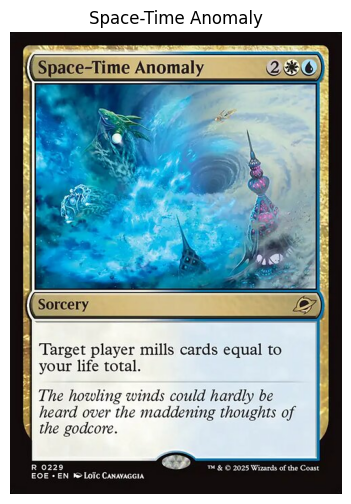

Carta: Space-Time Anomaly

Real:
  🔘 Colorless: 0
  🔴 Red: 0
  🔵 Blue: 1
  🟢 Green: 0
  ⚫ Black: 0
  ⚪ White: 1

Predicción:
  🔘 Colorless: 0.04
  🔴 Red: 0.03
  🔵 Blue: 0.97
  🟢 Green: 0.02
  ⚫ Black: 0.01
  ⚪ White: 0.94

Tu carta es azul y blanca.


In [15]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Usamos la lista de cartas que definimos en el primer dataframe.
# Sin embargo, se utilizarán los índices definidos después.
card_names = list(df['name'].values)

# Usamos el widget de ipwidgets:
search = widgets.Combobox(
    placeholder='Escribe el nombre de la carta: ',
    options=card_names, # Esta línea muestra el despliegue de sugerencias.
    description='Carta:',
    ensure_option=True,
    layout=widgets.Layout(width='400px')
)

# Mostrar el widget
button = widgets.Button(
    description='Mostrar',
    button_style='success',
    layout=widgets.Layout(width='120px')
)

box = widgets.HBox([search, button])
display(box)


# Desplegar la carta con el índice original.
def mostrar_carta(carta):
    clear_output(wait=True)
    display(box)

    if carta not in card_names:
        print("Carta no encontrada")
        return

    # Obtener el índicie original de la carta.
    idx_real = df.index[df['name'] == carta].tolist()[0]

    # Extraer el índice original de la carta.
    img_array = X[idx_real] # Imagen correcta
    true_vals = Y[idx_real] # Etiquetas correctas

    # Predicción con el modelo.
    pred = model.predict(img_array.reshape(1, *img_array.shape))[0]

    # Cargar la imágen original.
    img_path = os.path.join(card_directory, carta + ".jpg")
    img_original = cv2.imread(img_path)
    img_original = cv2.cvtColor(img_original, cv2.COLOR_BGR2RGB)

    # Mostrar imágen usando MatPlotLib.
    plt.figure(figsize=(5,6))
    plt.imshow(img_original)
    plt.title(carta)
    plt.axis('off')
    plt.show()

    # Mostrar resultados.
    print(f"Carta: {carta}\n")

    print("Real:")
    for (label, emoji), val in zip(color_labels, true_vals):
        print(f"  {emoji} {label}: {val}")

    print("\nPredicción:")
    for (label, emoji), val in zip(color_labels, pred):
        print(f"  {emoji} {label}: {val:.2f}")

    # Mostrar el texto que indica el color de la carta:
    # ESTABLECE EL NIVEL DE CONFIAZA a 0.6
    # MUY IMPORTANTE.
    threshold = 0.60
    colores_detectados = []

    for (label, emoji), val in zip(color_labels, pred):
        if val >= threshold:
            colores_detectados.append(label)

    # Genera el texto de predicción de la carta.
    if len(colores_detectados) == 0:
        print("\nNo se detectó ningún color con confianza suficiente.")
    else:
        traduccion = {
            "Colorless": "incolora",
            "Red": "roja",
            "Blue": "azul",
            "Green": "verde",
            "Black": "negra",
            "White": "blanca"
        }

        colores_texto = [traduccion[c] for c in colores_detectados]

        if len(colores_texto) == 1:
            frase = f"Tu carta es {colores_texto[0]}."
        else:
            frase = "Tu carta es " + " y ".join(colores_texto) + "."

        print("\n" + frase)

# Conectar el botón al widget.
def on_button_clicked(b):
    carta = search.value
    mostrar_carta(carta)

button.on_click(on_button_clicked)

# Exportamos el modelo para utilizar en otros códigos.

In [17]:
from google.colab import files
model.save("MTGResNet50.keras")
files.download("MTGResNet50.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>